# iLykei Lecture Series 

# Machine Learning

# Support Vector Machines

# Workshop 2

## Y.Balasanov, L.Nazarov &copy; iLykei 2017-22


This is Python version of Week 8 Workshop 2. Below is the list of packages used in the workshop.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.svm import SVC 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import cohen_kappa_score
import string

# Data
**This project compares gradient boosting and SVM models on ISOLET data**.    


In [2]:
# Actual example
# isolet data from 'https://archive.ics.uci.edu/ml/datasets/ISOLET'
dTrain = pd.read_csv('isolet1234.data.gz',header=None,prefix='V')
dTrain['isTest'] = False # add column, identifying test
print('dTrain',dTrain.shape)
dTest = pd.read_csv('isolet5.data.gz',header=None,prefix='V')
dTest['isTest'] = True # add column, identifying test
print('dTest',dTest.shape)
d = dTrain.append(dTest).rename({'V617':'target'}, axis='columns')
print('d',d.shape)
d['target'] = d.target.apply(lambda x: string.ascii_lowercase[int(x)-1])
d = d[(d.target=='m') | (d.target=='n')]
print('d',d.shape)
yColumn = 'isLetter'
d[yColumn] = d.target == 'n'
d[[yColumn]].head()

dTrain (6238, 619)
dTest (1559, 619)
d (7797, 619)
d (599, 619)


,isLetter
24,False
25,False
26,True
27,True
76,False


Normalize data.

In [3]:
scaler = StandardScaler()
trainX = scaler.fit_transform(d[~d.isTest].drop(['isTest','isLetter','target'],
                                                axis=1))
testX = scaler.transform(d[d.isTest].drop(['isTest','isLetter','target'],axis=1))
trainY = d.isLetter[~d.isTest].astype(int)
testY = d.isLetter[d.isTest].astype(int)

# SVM with radial kernel    

SVM with radial kernel (*'rbf'*) model has 2 main parameters:    

* Parameter $C$ is responsible for cost of misclassification in the "soft margin" version of SVM. In other words it controls the trade-off between bias and variance. A large C gives low bias and high variance by  penalizing more for misclasification. A small C allows higher bias and makes variance lower.    
* Parameter $\gamma$ defines smoothness of classification rule or how far the influence of a single observation goes. Low values of $\gamma$ expands the radius of influence and small values decrease it.  

Method *fit* of class *GridSearchCV* searches parameters on the grid *tuneGrid*.     
Keep default value of parameter *gamma* and change parameter *C* as sequence 1, 2, 4, 8, 16. By default optimal classification model is selected by finding maximum of accuracy.

In [4]:
clf = SVC(kernel='rbf',probability=True,random_state=0)
# Parameters grid to search
tuneGrid = {'C': 2**np.arange(5)}

grid = GridSearchCV(estimator = clf, param_grid = tuneGrid, 
                    n_jobs=-1,cv=5)
grid.fit(trainX,trainY)

GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=0), n_jobs=-1,
             param_grid={'C': array([ 1,  2,  4,  8, 16])})

Print summary of the optimization results and plot them

0.931250 with:  {'C': 1}
0.941667 with:  {'C': 2}
0.939583 with:  {'C': 4}
0.939583 with:  {'C': 8}
0.939583 with:  {'C': 16}


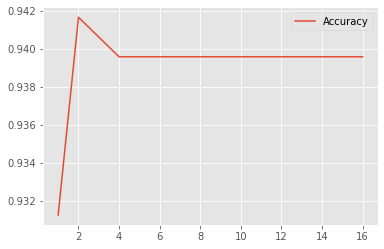

In [5]:
# summarize results
for mean,param in zip(grid.cv_results_['mean_test_score'],grid.cv_results_['params']):
    print("%f with: " % mean,param)
plt.plot(tuneGrid['C'],grid.cv_results_['mean_test_score'])
plt.legend(['Accuracy'])

Method *predict* gives class prediction for a new sample. Predict with the best parameters.

In [6]:
clf.set_params(C=grid.best_params_['C'])
clf.fit(trainX,trainY)
svmPred = clf.predict(testX)

Get confusion matrix of test data

In [7]:
svm_conf = confusion_matrix(testY,svmPred)
svm_conf

array([[55,  4],
       [ 9, 51]])

Prediction probabilities of test data classes can be calculated as

In [8]:
probs = clf.predict_proba(testX)
probs[:5]

array([[9.99946181e-01, 5.38185144e-05],
       [9.99302950e-01, 6.97049756e-04],
       [4.10720316e-06, 9.99995893e-01],
       [1.50629661e-02, 9.84937034e-01],
       [9.72515920e-01, 2.74840800e-02]])

The second column contains positive class probabilities.  

Plot the ROC curve and evaluate AUC (area under curve).

ROC AUC = 0.9683615819209039


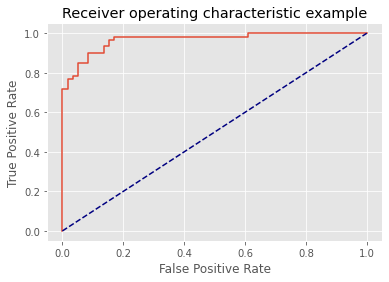

In [9]:
fpr, tpr, thresholds = roc_curve(testY, probs[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
print('ROC AUC =',roc_auc_score(testY, probs[:,1]))

# Gradient boosting    

Now use *GridSearchCV* for tuning parameters of Gradient Boosting classifier and compare results with SVM.

In [10]:
gbm = LGBMClassifier(max_depth=2,num_leaves=15, min_child_samples=2)
gbmGrid = {'n_estimators':[50,100, 150, 200]}

grid = GridSearchCV(estimator=gbm, param_grid=gbmGrid, n_jobs=-1,cv=5)
grid.fit(trainX,trainY)

# summarize results
for mean,param in zip(grid.cv_results_['mean_test_score'],grid.cv_results_['params']):
    print("%f with: " % mean,param)
gbm.set_params(n_estimators=grid.best_params_['n_estimators'])
gbm.fit(trainX,trainY)
gbmPred = gbm.predict(testX)
gbmProb = gbm.predict_proba(testX)
lgb_conf = confusion_matrix(testY,gbmPred)
lgb_conf

0.920833 with:  {'n_estimators': 50}
0.929167 with:  {'n_estimators': 100}
0.933333 with:  {'n_estimators': 150}
0.931250 with:  {'n_estimators': 200}


array([[54,  5],
       [ 5, 55]])

# Comparison   

Collect results for both models and compare them.

In [11]:
pd.DataFrame({'Accuracy':[np.trace(svm_conf)/np.sum(svm_conf),
                          np.trace(lgb_conf)/np.sum(lgb_conf)],
              'ROC AUC':[roc_auc_score(testY, probs[:,1]),
                         roc_auc_score(testY, gbmProb[:,1])],
              'kappa':[cohen_kappa_score(testY, svmPred),
                         cohen_kappa_score(testY, gbmPred)]},
             index = ['SVM','LightGBM'])

,Accuracy,ROC AUC,kappa
SVM,0.890756,0.968362,0.781651
LightGBM,0.915966,0.969774,0.831921
